In [1]:
from core import *

from math import sqrt
import numpy as np
import random
import logging
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)
# logging.debug("test")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def eV_to_J(E):
    return E * 1.60217662e-19

def J_to_eV(E):
    return J * 6.24150913e18

def to_percent(observed, actual):
    return abs((observed - actual) / actual) * 100

random.seed()

# Uniform Fields

### Nonrelativistic Velocities

By the definition of kinetic energy, a nonrelativistic particle should have a velocity that satisfies $\frac{1}{2}mv^2 = K$. Furthermore, the kinetic energy of a charged particle should not change when under the sole influence of a magnetic field. Therefore, we should find

$$v = \sqrt{\frac{2K_0}{m}},$$

where $K_0$ is the initial kinetic energy, for all points in time.

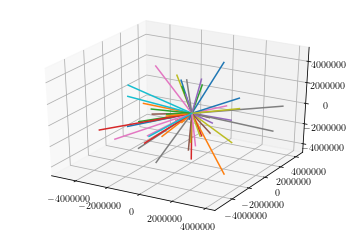

In [8]:
T = 1       # Total time
dt = 1e-3   # Simulation time step
trials = 50 # Number of runs

system = Solver(BorisNonrel(dt)) # Nonrelativistic integrator

def v_nonrel(K, m):
    return sqrt(2. * K / m)

analytical_v_nonrel = np.zeros(trials)
numerical_v_nonrel = np.zeros(trials)

for i in range(trials):
    # Randomly generate positions, velocity directions, and kinetic energies
    r = np.random.default_rng().normal(0., 10., 3)     # 3D normal distribution, sigma = 10 m
    v_dir = np.random.default_rng().normal(0., 1., 3)  # 3D normal distribution, sigma = 1 m
    K = np.random.default_rng().uniform(0., 1e2)       # 1D uniform distribution from 0 eV to 1e2 eV
    
    analytical_v_nonrel[i] = v_nonrel(eV_to_J(K), me)
    
    system.add_particle(Particle(r, v_dir, K, -qe, me))
    
system.solve(T, ['position', 'velocity'])    

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, particle in enumerate(system.particles):
    numerical_v_nonrel[i] = (np.linalg.norm(particle.history['velocity'][-1]))
    ax.plot(particle.history['position'][:, 0], particle.history['position'][:, 1], particle.history['position'][:, 2])

plt.show()

In [9]:
# Nonrelativistic velocity results

error = to_percent(numerical_v_nonrel, analytical_v_nonrel)

# print('Error (%): ' + ' '.join(f'{x:.2f}\n' for x in error))
print(f'Average Error (%): {sum(error) / trials:.2f}')

Average Error (%): 0.01


### Relativistic Velocities

When relativistic effects are included, the particle's kinetic energy is described by its total energy minus its rest energy, i.e.

$$K = mc^2(\gamma - 1).$$

Since the tested particles are only under the influence of a magnetic field, we should find a constant velocity of

$$v = \frac{c}{\gamma}\sqrt{\gamma^2 - 1},$$

where $\gamma = 1 + \frac{K_0}{mc^2}$ and $K_0$ is the initial kinetic energy.

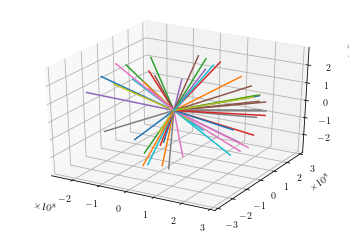

In [10]:
T = 1
dt = 1e-3
trials = 50

system = Solver(BorisRel(dt))

def gamma_from_E(K, m):
    return 1 + K / (m * c**2)

def v_rel(g):
    return (c / g) * sqrt(g**2 - 1)

analytical_v_rel = np.zeros(trials)
numerical_v_rel = np.zeros(trials)

for i in range(trials):
    # Randomly generate positions, velocity directions, and kinetic energies
    r = np.random.default_rng().normal(0., 10., 3)     # 3D normal distribution, sigma = 10 m
    v_dir = np.random.default_rng().normal(0., 1., 3)  # 3D normal distribution, sigma = 1 m
    K = np.random.default_rng().uniform(0., 1e7)        # 1D uniform distribution from 0 eV to 1e7 eV
    
    g = gamma_from_E(eV_to_J(K), me)
    analytical_v_rel[i] = v_rel(g)
    
    system.add_particle(Particle(r, v_dir, K, -qe, me))
    
system.solve(T, ['position', 'velocity'])    

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, particle in enumerate(system.particles):
    numerical_v_rel[i] = (np.linalg.norm(particle.history['velocity'][-1]))
    ax.plot(particle.history['position'][:, 0], particle.history['position'][:, 1], particle.history['position'][:, 2])

plt.show()

In [11]:
# Relativistic velocity results

error = to_percent(numerical_v_rel, analytical_v_rel)

# print('Error (%): ' + ' '.join(f'{x:.2f}\n' for x in error))
print(f'Average Error (%): {sum(error) / trials:.2f}')

Average Error (%): 0.00


### Nonrelativistic Gyrofrequency and Gyroradius

The gyroradius of a nonrelativistic charged particle may be found by combining the requirement for circular motion,

$$F = \frac{mv_{\perp}^2}{r},$$

with the Lorentz force in the case of a zero electric field,

$$\mathbf{F} = q\mathbf{v}\times\mathbf{B} \to F = |q|v_{\perp}B.$$

Solving for $r$ yields

$$r = \frac{mv_{\perp}}{|q|B}.$$

From this, we can get the gyrofrequency by setting $\omega r = v_{\perp}$, i.e.

$$\omega = \frac{|q|B}{m}.$$

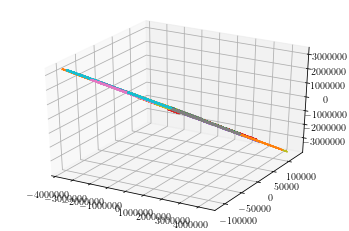

In [12]:
B = UniformField(np.random.default_rng().uniform(1e-12, 1e-6), np.random.default_rng().normal(0., 1., 3))
T = 1
dt = 1e-3
trials = 50

system = Solver(BorisNonrel(dt), B)
    
def gyrofreq_nonrel(m, q, B):
    return abs(q) * np.linalg.norm(B) / m

def gyrorad_nonrel(m, q, B, v):
    v_perp = np.linalg.norm(v - (np.dot(v, B) / np.dot(B, B)) * B)
    return m * v_perp / (abs(q) * np.linalg.norm(B))

analytical_gyrofreq_nonrel = np.zeros(trials)
numerical_gyrofreq_nonrel = np.zeros(trials)

analytical_gyrorad_nonrel = np.zeros(trials)
numerical_gyrorad_nonrel = np.zeros(trials)

for i in range(trials):
    # Randomly generate positions, velocity directions, and kinetic energies
    r = np.random.default_rng().normal(0., 10., 3)     # 3D normal distribution, sigma = 10 m
    v_dir = np.random.default_rng().normal(0., 1., 3)  # 3D normal distribution, sigma = 1 m
    K = np.random.default_rng().uniform(0., 1e2)       # 1D uniform distribution from 0 eV to 1e2 eV
    
    v = v_nonrel(eV_to_J(K), me) * v_dir / (np.linalg.norm(v_dir))
    
    analytical_gyrofreq_nonrel[i] = gyrofreq_nonrel(me, -qe, B.at(r))
    analytical_gyrorad_nonrel[i] = gyrorad_nonrel(me, -qe, B.at(r), v)
    
    system.add_particle(Particle(r, v_dir, K, -qe, me))
    
system.solve(T, ['position', 'velocity', 'gyrofreq', 'gyroradius'])    

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, particle in enumerate(system.particles):
    numerical_gyrofreq_nonrel[i] = np.linalg.norm(particle.history['gyrofreq'][-1])
    numerical_gyrorad_nonrel[i] = np.linalg.norm(particle.history['gyroradius'][-1])
    ax.plot(particle.history['position'][:, 0], particle.history['position'][:, 1], particle.history['position'][:, 2])

plt.show()

In [13]:
# Nonrelativistic yrofrequency results

error = to_percent(numerical_gyrofreq_nonrel, analytical_gyrofreq_nonrel)

# print('Error (%): ' + ' '.join(f'{x:.2f}\n' for x in error))
print(f'Average Error (%): {sum(error) / trials:.2f}')

Average Error (%): 0.01


In [14]:
# Nonrelativistic gyroradius results

error = to_percent(numerical_gyrorad_nonrel, analytical_gyrorad_nonrel)

# print('Error (%): ' + ' '.join(f'{x:.2f}\n' for x in error))
print(f'Average Error (%): {sum(error) / trials:.2f}')

Average Error (%): 0.00


### Relativistic Gyrofrequency and Gyroradius

The Lorentz force is already covariant, so we simply need to change the centripetal force requirement in our previous derivation. We can enforce compatibility with relativity by expressing it in the terms of momentum and taking the relativistic definition,

$$F = \frac{p_{\perp}^2}{mr} = \frac{\gamma m v_{\perp}^2}{r}.$$

This altered requirement corrects the gyroradius and gyrofrequency expressions to read

$$r = \frac{\gamma m v_{\perp}}{|q|B}$$

and

$$\omega = \frac{|q|B}{\gamma m}.$$

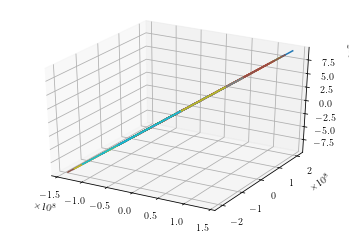

In [15]:
B = UniformField(np.random.default_rng().uniform(1e-12, 1e-6), np.random.default_rng().normal(0., 1., 3))
T = 1
dt = 1e-3
trials = 50

system = Solver(BorisRel(dt), B)
    
def gyrofreq_rel(m, q, B, g):
    return (abs(q) * np.linalg.norm(B)) / (g * m)

def gyrorad_rel(m, q, B, v, g):
    v_perp = np.linalg.norm(v - (np.dot(v, B) / np.dot(B, B)) * B)
    return (g * m * v_perp) / (abs(q) * np.linalg.norm(B))

analytical_gyrofreq_rel = np.zeros(trials)
numerical_gyrofreq_rel = np.zeros(trials)

analytical_gyrorad_rel = np.zeros(trials)
numerical_gyrorad_rel = np.zeros(trials)

for i in range(trials):
    # Randomly generate positions, velocity directions, and kinetic energies
    r = np.random.default_rng().normal(0., 10., 3)     # 3D normal distribution, sigma = 10 m
    v_dir = np.random.default_rng().normal(0., 1., 3)  # 3D normal distribution, sigma = 1 m
    K = np.random.default_rng().uniform(0, 1e7)        # 1D uniform distribution from 0 eV to 1e7 eV
    
    g = gamma_from_E(eV_to_J(K), me)
    v = v_rel(g) * v_dir / (np.linalg.norm(v_dir))
    
    analytical_gyrofreq_rel[i] = gyrofreq_rel(me, -qe, B.at(r), g)
    analytical_gyrorad_rel[i] = gyrorad_rel(me, -qe, B.at(r), v, g)
    
    system.add_particle(Particle(r, v_dir, K, -qe, me))
    
system.solve(T, ['position', 'velocity', 'gyrofreq', 'gyroradius'])    

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, particle in enumerate(system.particles):
    numerical_gyrofreq_rel[i] = np.linalg.norm(particle.history['gyrofreq'][-1])
    numerical_gyrorad_rel[i] = np.linalg.norm(particle.history['gyroradius'][-1])
    ax.plot(particle.history['position'][:, 0], particle.history['position'][:, 1], particle.history['position'][:, 2])

plt.show()

In [16]:
# Relativistic yrofrequency results

error = to_percent(numerical_gyrofreq_rel, analytical_gyrofreq_rel)

# print('Error (%): ' + ' '.join(f'{x:.2f}\n' for x in error))
print(f'Average Error (%): {sum(error) / trials:.2f}')

Average Error (%): 0.01


In [17]:
# Relativistic gyroradius results

error = to_percent(numerical_gyrorad_rel, analytical_gyrorad_rel)

# print('Error (%): ' + ' '.join(f'{x:.2f}\n' for x in error))
print(f'Average Error (%): {sum(error) / trials:.2f}')

Average Error (%): 0.01


### Guiding Center and Dipole Tests

No handles with labels found to put in legend.


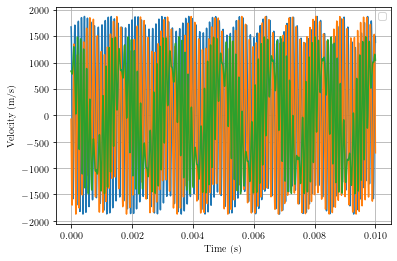

In [51]:
B = MagneticDipoleField(10, np.array([0., 0., 4.]))

T = 1e-2
dt = 1e-6

r = np.array([0., 1., 0.])
v_dir = np.array([1., 0., .5])
K = 1e-5

system = Solver(BorisNonrel(dt), B)
system.add_particle(Particle(r, v_dir, K, -1e-20, me))
system.solve(T, ['velocity', 'position', 'gyrofreq', 'gyroradius', 'pitch_angle'])

system.particles[0].gca(dt)

plot_field(B, 10, 10, 10, 6)

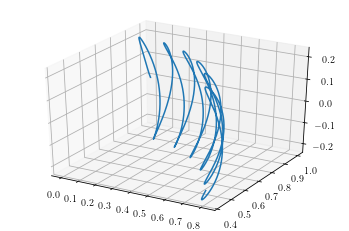

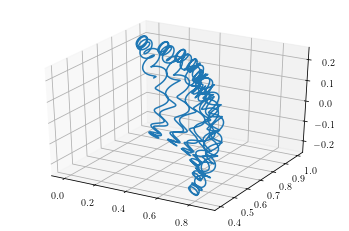

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
particle = system.particles[0]
ax.plot(particle.history['gca'][:, 0], particle.history['gca'][:, 1], particle.history['gca'][:, 2])
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
particle = system.particles[0]
ax.plot(particle.history['position'][:, 0], particle.history['position'][:, 1], particle.history['position'][:, 2])
plt.show()

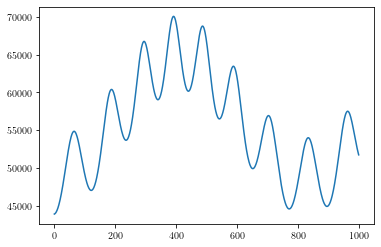

In [58]:
plt.plot(particle.history['gyrofreq'][:-9000])

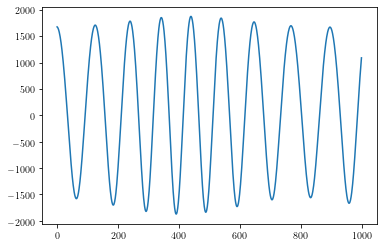

In [59]:
plt.plot(particle.history['velocity'][:-9000, 0])